<h1> <center> MNIST Classification Using Dense Network </center> </h1>
<hr></hr>

<h2> <b>Step 1:</b> Importing all the required packages. </h2>

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt

<hr></hr>
<h2> <b>Step 2:</b> Loading the Dataset </h2>

In [2]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())





<hr></hr>
<h2> <b>Step 3:</b> Make Dataset Iterable </h2>

**A few explnations:**

- Because we have 60000 training samples (images), we need to split them up to small groups (batches) and pass these batches of samples to our feedforward neural network subsesquently.
- If we have 60,000 images and we want a batch size of 100, then we would have 600 iterations where each iteration involves passing 600 images to the model and getting their respective predictions.

- **Epoch:** An epoch means that you have successfully passed the whole training set, 60,000 images, to the model. Continuing our example above, an epoch consists of 600 iterations. If we want to go through the whole dataset 5 times (5 epochs) for the model to learn, then we need 3000 iterations (600 x 5).

- As we have gone through above, we want to have 5 epochs, where each epoch would have 600 iterations and each iteration has a batch size of 100. Because we want 5 epochs, we need a total of 3000 iterations.

In [3]:
batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

<hr></hr>
<h2> <b>OPTIONAL STEP: Just to display the dataset for better understanding</b> </h2>

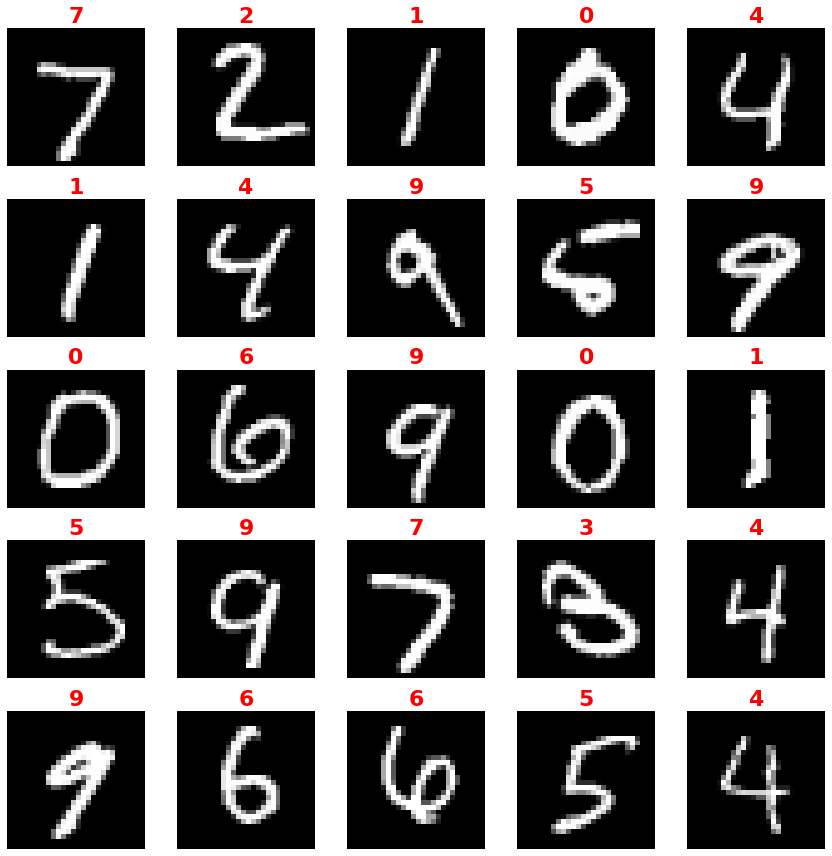

In [4]:
examples = iter(test_loader)
example_data, example_targets = examples.next()
plt.figure(figsize = (12, 12))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(example_data[i][0], cmap='gray')
  plt.title(example_targets.numpy()[i], color = 'red', fontweight = 'bold', fontsize = 22)
  plt.axis('off')

plt.tight_layout()
plt.show() 

<hr></hr>
<h2><b> Step 4: Using PyTorch to Build the Model </b></h2>

We, will use the TensorFlow library to build the model for training the data as follows:

In [5]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 

        # Non-linearity
        self.relu = nn.ReLU()

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        # Linear function  # LINEAR
        out = self.fc1(x)

        # Non-linearity  # NON-LINEAR
        out = self.relu(out)

        # Linear function (readout)  # LINEAR
        out = self.fc2(out)
        return out

<hr></hr>
<h2><b> Step 5: Instantiate Model Class </b></h2>


In [6]:
input_dim = 28*28
hidden_dim = 100
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

<hr></hr>

**Instantiating the Loss Class**

<hr></hr>

In [7]:
criterion = nn.CrossEntropyLoss()

<hr></hr>

**Instantiating the Optimizer Class**

<hr></hr>

In [8]:
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 



<hr></hr>
<h2> <b>OPTIONAL STEP: Viewing the Parameters</b> </h2>

This would return a Python generator object, so you need to call list on the generator object to access anything meaningful.

In [9]:
print(model.parameters())

<generator object Module.parameters at 0x7f1afcebb8d0>


Here we call list on the generator object and getting the length of the list. This would return 4 because we've 2 linear layers, and each layer has 2 groups of parameters W and b.

In [10]:
print(len(list(model.parameters())))

4


Our first linear layer parameters, $W_1$, would be of size $100 × 784$. This is because we've an input size of $784 (28 × 28)$ and a hidden size of $100$.

In [11]:
# FC 1 Parameters 
print(list(model.parameters())[0].size())

torch.Size([100, 784])


Our first linear layer bias parameters, $b_1$, would be of size $100$ which is our hidden size.

In [12]:
# FC 1 Bias Parameters
print(list(model.parameters())[1].size())

torch.Size([100])


Our second linear layer is our readout layer, where the parameters $W_2$ would be of size $10 × 100$. This is because our output size is $10$ and hidden size is $100$.

In [13]:
# FC 2 Parameters
print(list(model.parameters())[2].size())

torch.Size([10, 100])


Likewise our readout layer's bias $b_2$ would just be $10$, the size of our output.

In [14]:
# FC 2 Bias Parameters
print(list(model.parameters())[3].size())

torch.Size([10])


<hr></hr>
<h2><b> Step 6: Train Model </b></h2>

- Process
  1. Convert inputs to tensors with gradient accumulation capabilities
  2. Clear gradient buffers
  3. Get output given inputs
  4. Get loss
  5. Get gradients w.r.t. parameters
  6. Update parameters using gradients
    	```
      parameters = parameters - learning_rate * parameters_gradients
      ```
  7. REPEAT

In [15]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 28*28).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images with gradient accumulation capabilities
                images = images.view(-1, 28*28).requires_grad_()

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.27346211671829224. Accuracy: 92.73999786376953
Iteration: 1000. Loss: 0.09823954850435257. Accuracy: 94.8499984741211
Iteration: 1500. Loss: 0.20177048444747925. Accuracy: 95.6500015258789
Iteration: 2000. Loss: 0.08134855329990387. Accuracy: 96.29000091552734
Iteration: 2500. Loss: 0.10158900171518326. Accuracy: 96.52999877929688
Iteration: 3000. Loss: 0.1616268754005432. Accuracy: 96.88999938964844


<hr></hr>

<h2><b> Step 5: Prediction </b></h2>

Let's see what our model predicts for future images.
<hr></hr>


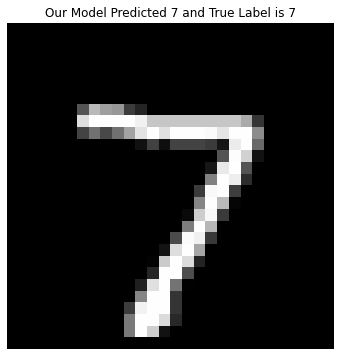

In [16]:
import numpy as np
img = test_loader.dataset.data[0]
# img = img.numpy()
lab = test_loader.dataset.targets[0]
lab = lab.numpy()
img1 = img.view(-1, 28*28)
y = model(img1.float())

plt.figure(figsize = (6, 6))
plt.imshow(img, cmap = 'gray')
plt.title('Our Model Predicted {} and True Label is {}'.format(y.argmax().numpy(), lab))
plt.axis('off')
plt.show()

<hr></hr>
<hr></hr>
<h1> <center> MNIST Classification Using Convolutional Neural Network </center> </h1>

**Steps**
- Step 1: Load Dataset
- Step 2: Make Dataset Iterable
- Step 3: Create Model Class
- Step 4: Instantiate Model Class
- Step 5: Instantiate Loss Class
- Step 6: Instantiate Optimizer Class
- Step 7: Train Model
<hr></hr>




<hr></hr>

<h2><b> Step 1: Load Dataset </b></h2>

In [17]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [18]:
# print(train_dataset.train_data.size())
# print(train_dataset.train_labels.size())
# print(test_dataset.test_data.size())
# print(test_dataset.test_labels.size())

torch.Size([60000, 28, 28])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")




<hr></hr>

<h2><b> Step 2: Make Dataset Iterable </b></h2>

<hr></hr>

In [22]:
batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)




<hr></hr>

<h2><b> Step 3: Create Model Class </b></h2>

<hr></hr>

In [29]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # # Convolution 2
        # self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        # self.relu2 = nn.ReLU()

        # # Max pool 2
        # self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32 * 14 * 14, 100) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max pool 1
        out = self.maxpool1(out)

        # # Convolution 2 
        # out = self.cnn2(out)
        # out = self.relu2(out)

        # # Max pool 2 
        # out = self.maxpool2(out)

        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)

        return out




<hr></hr>

<h2><b>Step 4: Instantiate Model Class </b></h2>

<hr></hr>

In [30]:
model = CNNModel()




<hr></hr>

<h2><b> Step 5: Instantiate Loss Class </b></h2>

<hr></hr>

In [31]:
criterion = nn.CrossEntropyLoss()




<hr></hr>

<h2><b> Step 6: Instantiate Optimizer Class </b></h2>

<hr></hr>

In [32]:
learning_rate = 0.001

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  




<hr></hr>

<h2><b> OPTIONAL: Print model's parameter </b></h2>

<hr></hr>

In [33]:
print(model.parameters())

print(len(list(model.parameters())))

# Convolution 1: 32 Kernels
print(list(model.parameters())[0].size())

# Convolution 1 Bias: 32 Kernels
print(list(model.parameters())[1].size())

# Convolution 2: 32 Kernels with depth = 16
print(list(model.parameters())[2].size())

# Convolution 2 Bias: 32 Kernels with depth = 16
print(list(model.parameters())[3].size())

# Fully Connected Layer 1
print(list(model.parameters())[4].size())

# Fully Connected Layer Bias
print(list(model.parameters())[5].size())

<generator object Module.parameters at 0x7f1afa4f1e50>
6
torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([100, 6272])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])



<hr></hr>

<h2><b> Step 7: Train Model </b></h2>

**Process**
1. Convert inputs to tensors with gradient accumulation abilities
  - CNN Input: (1, 28, 28)
  - Feedforward NN Input: (1, 28*28)
2. Clear gradient buffets
3. Get output given inputs
4. Get loss
5. Get gradients w.r.t. parameters
6. Update parameters using gradients
  ```
  parameters = parameters - learning_rate * parameters_gradients
  ```
7. REPEAT
<hr></hr>




In [34]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images
        images = images.requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images
                images = images.requires_grad_()

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.1713674068450928. Accuracy: 57.02000045776367
Iteration: 1000. Loss: 1.961664080619812. Accuracy: 64.93000030517578
Iteration: 1500. Loss: 1.6829806566238403. Accuracy: 71.93000030517578
Iteration: 2000. Loss: 1.1953661441802979. Accuracy: 77.3499984741211
Iteration: 2500. Loss: 0.911604642868042. Accuracy: 81.58000183105469
Iteration: 3000. Loss: 0.7043841481208801. Accuracy: 84.58999633789062


<hr></hr>

<h2><b> Step 8: Prediction </b></h2>

Let's see what our model predicts for future images.
<hr></hr>

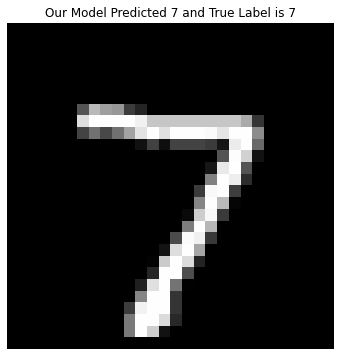

In [43]:
import numpy as np
img = test_loader.dataset.data[0]
img = img[None,None,:,:]
lab = test_loader.dataset.targets[0]
lab = lab.numpy()
y = model(img.float())

plt.figure(figsize = (6, 6))
plt.imshow(img[0,0,:,:], cmap = 'gray')
plt.title('Our Model Predicted {} and True Label is {}'.format(y.argmax().numpy(), lab))
plt.axis('off')
plt.show()